# Introduction to Coil Sets and Green's Functions

#### The purpose of this tutorial is to develop familiarity with the fundamental objects we will need to create, manipulate, and analyze magnetic configurations.

#### The three objectives of this tutorial are enumerated below:
1. Create coil sets and transform them through translations and rotations.
2. Create suitable meshes and using them to create Green's functions for flux and magnetic field components
3. Understand and plot the results of goals 1 and 2

Just like any other python notebook we start with importing standard libraries as well as our project's specific functionality

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pleiades import RectangularCoil

Now we will create an instance of the `RectangularCoil` class as it is by far the most common coil set used for building electromagnets for plasma physics or fusion experiments. We create a `RectangularCoil` by specifying at a minimum the centroid `(r0, z0)` of the regular array of current filaments in cylindrical coordinates and with SI units.

In [2]:
rc1 = RectangularCoil(1, 0.5, nr=10, nz=10, dr=.01, dz=.01)

100


Now let's see what attributes this coil has

In [7]:
print(rc1.centroid)
print(rc1.area)
print(rc1.current)
print(rc1.current_density/1E6)

[1.  0.5]
0.01
1.0
0.01


Now we will try our hand at plotting some of this data as well as the visulaizations. to access the fields like psi, B_R, and B_Z we simply call their attributes from the brb object as shown below.

In [8]:
from pleiades import RectGrid

grid = RectGrid(rmin=0, rmax=3, zmin=0, zmax=3)

rc1.compute_greens(grid.R, grid.Z)


TypeError: Can't instantiate abstract class RectGrid with abstract methods _R, _Z

Now lets look at an equilibrium... A few parameters are important here: namely the plasma limiting radius, a, the peak pressure, P0, the exponent of the pressure profile, alpha, and the plasma beta at the origin with respect to the vacuum field. Once we build the pressure function and get the Green's function for plasma currents on the grid we are ready to run compute_equilibrium and write out an eqdsk. When this cell is run you should see the iteration number and error print to the screen and the error should decrease to a small value below 1E-10 by default to know the computation has converged.

In [5]:
# setup pressure profile and compute P0 for a given desired initial beta
a = .6
alpha = 2.0
beta0 = .1
B0 = locs_to_vals(R,Z,B,[(0,0)])[0]
P0 = beta0*B0**2/(2*4*np.pi*1E-7)
print("pressure ", P0)
# build pressure function of cylindrical radius
Pfunc = lambda x: P0*(1-(x/a)**2)**alpha if x < a else 0
# get greens function for plasma currents
gplas = get_gpsi(R,Z)
# compute equilibrium
psieq,plas_currents,pfit = compute_equilibrium(R,Z,Pfunc,psi,gplas,maxiter=400,plotit=False)
write_eqdsk(R,Z,psi,plas_currents,"mfnpeqdsk1.txt","MFNP_Mirror Equilib")
P = pfit(psi.flatten()).reshape(psi.shape)
jphi = plas_currents/((R[0,1]-R[0,0])*(Z[1,0]-Z[0,0]))

pressure  34442.30411604662
computing gpsi blocks...
creating reflected block matrix
building huge matrix...
returning...
0
1
1
3.6922272594304535
2
0.06845762518044574
3
0.014266553608904232
4
0.00025437709220111574
5
7.434049741218316e-05
6
1.230864915575634e-06
7
4.035268383143511e-07
8
6.533988081366794e-09
9
2.2208735451358545e-09
10
3.683305527097399e-11


Below we will plot some flux lines as well as the diamagnetic current density j_phi in A/m^2 in the colormap. We've also included a demonstration of tracing field lines which can be used to interpolate values along a field line for stability calculations as well as flux surface averaging.

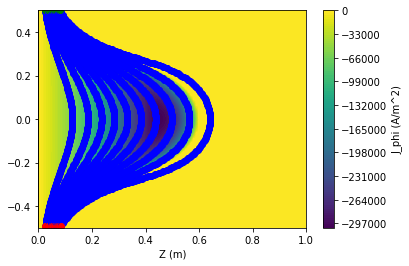

In [6]:
fig,ax = plt.subplots()
cf = ax.contourf(R,Z,jphi,101)
cs = ax.contour(R,Z,psieq,psi_space,colors="k")
for clev in psi_space[1:]:
    flpts = get_fieldlines(cs,clev,start_coord=(0.05,.5),end_coord=(0.05,-0.5),clockwise=True)
    ax.plot(flpts[:,0],flpts[:,1],"bo")
    ax.plot(flpts[0,0],flpts[0,1],"go")
    ax.plot(flpts[-1,0],flpts[-1,1],"ro")
ax.set_xlabel("R (m)")
ax.set_xlabel("Z (m)")
cbar = fig.colorbar(cf)
cbar.set_label("J_phi (A/m^2)")
plt.show()

Here let's plot a slice of B along the axis of symmetry.

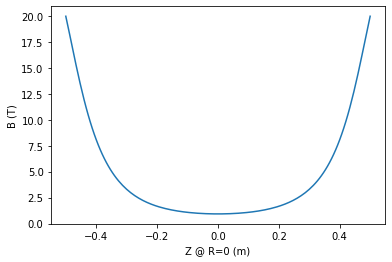

In [7]:
#### Plotting 
# plot slice of B as function of Z at R=0
ridx = np.abs(R[0,:]).argmin()
plt.plot(Z[:,ridx],B[:,ridx])
plt.xlabel("Z @ R=0 (m)")
plt.ylabel("B (T)")
plt.show()

Now let's look at how the flux lines change with finite plasma beta. the black lines are the vacuum field lines and green are the equilibrium field line values for the given beta and pressure profile. The red line shows the limiting flux surface.

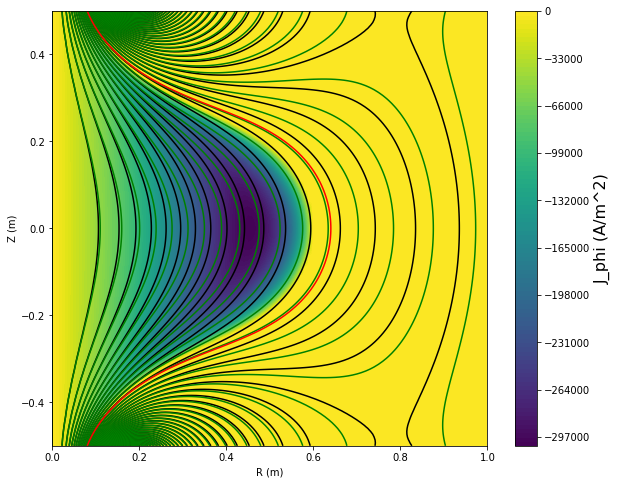

In [8]:
# plot up close flux lines and J_phi
fig,ax = plt.subplots(figsize=(10,8))
#cf = ax.contourf(R,Z,B,101,cmap="rainbow",locator=ticker.LogLocator(),zorder=0)
cf = ax.contourf(R,Z,jphi,101,zorder=0)
cs = ax.contour(R,Z,psi,51,colors='k',zorder=1)
cs1 = ax.contour(R,Z,psieq,51,colors='g',zorder=1)
cs = ax.contour(R,Z,psieq,(psi_lim,),colors='r',zorder=1)
cbar = fig.colorbar(cf)
cbar.set_label("J_phi (A/m^2)",fontsize=16)
ax.set_xlim(0,1.0)
ax.set_ylabel("Z (m)")
ax.set_xlabel("R (m)")
ax.set_ylim(-.5,.5)
ax.set_aspect('equal')
ax.add_collection(PatchCollection(brb.patches,match_original=True))
plt.show()